Importing all required libraries and functions first

In [1]:

import os
import time
import bm3d
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.metrics import structural_similarity

Defining functions for Artificial Noise-Adding Techniques
Gaussian + Blur, as defined below

In [ ]:
def add_blur(image, kernel_size=3): 
    kernel = np.ones((kernel_size, kernel_size))/(kernel_size**2)
    blurred = convolve2d(image, kernel, mode='same')
    return (blurred)

def add_noise(image, sigma=20): #Gaussian noise
    image = image + np.random.normal(0, sigma, image.shape)
    return (add_blur(image, 3))

Defining functions for alternate Artificial Noise Technique
Salt 'n Pepper + Blur, as below 

In [2]:
def add_blur(image, kernel_size=3): 
    kernel = np.ones((kernel_size, kernel_size))/(kernel_size**2)
    blurred = convolve2d(image, kernel, mode='same')
    return (blurred)

def add_noise(image, sigma=0.1): #Salt-and-Pepper noise
    noisy = image.copy()
    noisy[np.random.rand(*image.shape) < sigma] = 0
    noisy[np.random.rand(*image.shape) < sigma] = 255
    return (add_blur(noisy, 3))

Defining functions for Testing Methodology - PSNR and SSIM

In [3]:
def PSNR (original, processed):
    error = np.mean((original - processed)**2)
    if error == 0:
        return 100
    PIXEL_MAX = 255.0
    return (20*np.log10(PIXEL_MAX/np.sqrt(error)))

def SSIM (original, processed):
    return (structural_similarity (original, processed, multichannel=True))

Defining functions for Median Filter and conversion of images to grayscale

In [4]:
def grayscale(img):
	return np.dot(img[...,:3], [0.299, 0.587, 0.114])

def median_filter(data, kernel_size):
    temp = []
    indexer = kernel_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):
        for j in range(len(data[0])):
            for k in range(kernel_size):
                if i + k - indexer < 0 or i + k - indexer > len(data) - 1:
                    for c in range(kernel_size):
                        temp.append(0)
                else:
                    if j + k - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for x in range(kernel_size):
                            temp.append(data[i + k - indexer][j +  x - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

Creating arrays for Image Names/Locations, SSIM, PSNR lists and other processed values

In [5]:
images = ["dataset/pixel.jpg", "dataset/1to1.jpg", "dataset/fashion.jpg", "dataset/lena.jpg", "dataset/nature.jpg"]
image_list = []
noisy_image_list = []
denoised_image_bm3d = []
denoised_image_median = []

psnr_noisy_list = []
ssim_noisy_list = []

bm3d_times = []
bm3d_ssim = []
bm3d_psnr = []

median_times = []
median_ssim = []
median_psnr = []

Importing images, converting to grayscale and saving to arrays

In [6]:
for image in images:
    image = os.path.join(image) 
    image_list.append(grayscale(plt.imread(image)))

for image in image_list:
    noisy_image_list.append(add_noise(image, 0.1))

Processing images with Median Filter, BM3D and saving to arrays. 
Images are also being stored locally.

In [7]:
count = 1

for image in noisy_image_list:
    start = time.time()
    denoised = median_filter(image, 3)
    end = time.time()
    denoised_image_median.append(denoised)
    img = os.path.join("processed_median/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    median_times.append(end - start)

    denoised = 0
    
    start = time.time()
    denoised = bm3d.bm3d(image, sigma_psd=1, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    end = time.time()
    denoised_image_bm3d.append(denoised)
    img = os.path.join("processed_bm3d/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    bm3d_times.append(end - start)
    count += 1    

Processing PSNR, SSIM tests and saving values to arrays

In [ ]:
for i in range(len(images)):
    print(image_list[i].shape)
    print(noisy_image_list[i].shape)
    print(denoised_image_bm3d[i].shape)
    print(denoised_image_median[i].shape)
    

In [8]:
for i in range(len(images)):
    psnr_noisy_list.append(PSNR(image_list[i], noisy_image_list[i]))
    ssim_noisy_list.append(SSIM(image_list[i], noisy_image_list[i]))
    bm3d_ssim.append(SSIM(image_list[i], denoised_image_bm3d[i]))
    bm3d_psnr.append(PSNR(image_list[i], denoised_image_bm3d[i]))
    median_ssim.append(SSIM(image_list[i], denoised_image_median[i]))
    median_psnr.append(PSNR(image_list[i], denoised_image_median[i]))

Plotting PSNR Graphs for the two filters and in noisy state

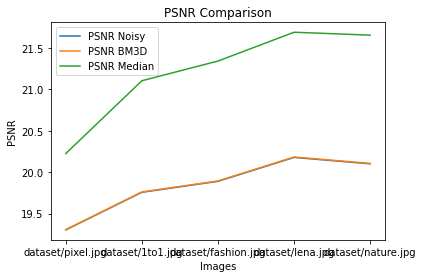

In [9]:
plt.plot(images, psnr_noisy_list, label="PSNR Noisy")
plt.plot(images, bm3d_psnr, label="PSNR BM3D")
plt.plot(images, median_psnr, label="PSNR Median")

plt.xlabel("Images")
plt.ylabel("PSNR")

plt.title("PSNR Comparison")
plt.legend()
plt.show()

Plotting SSIM Graphs for the two filters and in noisy state

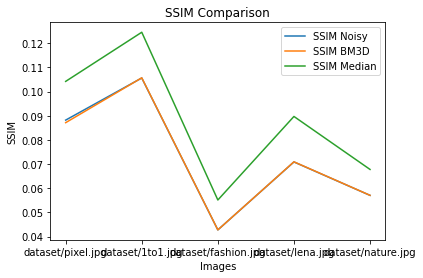

In [10]:
plt.plot(images, ssim_noisy_list, label="SSIM Noisy")
plt.plot(images, bm3d_ssim, label="SSIM BM3D")
plt.plot(images, median_ssim, label="SSIM Median")

plt.xlabel("Images")
plt.ylabel("SSIM")

plt.title("SSIM Comparison")
plt.legend()
plt.show()

Plotting Time Graphs for the two filters and in noisy state

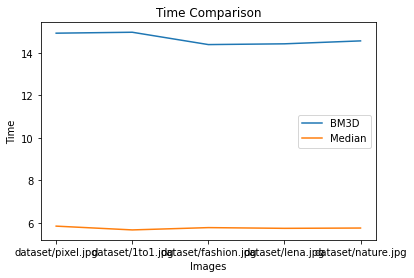

In [11]:
plt.plot(images, bm3d_times, label="BM3D")
plt.plot(images, median_times, label="Median")

plt.xlabel("Images")
plt.ylabel("Time")

plt.title("Time Comparison")
plt.legend()
plt.show()